# Visualising the flight paths that link the World’s continents with Python

In [1]:
import pandas as pd

airports = pd.read_csv("flight-data/airports.dat", delimiter=',', names=['id', 'name', 'city', 'country', 'iata',
                                                                   'icao', 'lat', 'long', 'altitude', 'timezone',
                                                                   'dst', 'tz', 'type', 'source'])

print(airports)

         id                                         name          city  \
0         1                               Goroka Airport        Goroka   
1         2                               Madang Airport        Madang   
2         3                 Mount Hagen Kagamuga Airport   Mount Hagen   
3         4                               Nadzab Airport        Nadzab   
4         5  Port Moresby Jacksons International Airport  Port Moresby   
...     ...                                          ...           ...   
7693  14106                          Rogachyovo Air Base        Belaya   
7694  14107                        Ulan-Ude East Airport      Ulan Ude   
7695  14108                         Krechevitsy Air Base      Novgorod   
7696  14109                  Desierto de Atacama Airport       Copiapo   
7697  14110                           Melitopol Air Base     Melitopol   

               country iata  icao        lat        long  altitude timezone  \
0     Papua New Guinea  GKA  AYG

<p>The data can be plotted as a scatter plot to show the location of the worlds airports, or at least the airports included within this dataset. As usual with anything on a global scale this map largely just becomes a proxy for population density but it is still interesting to see the distribution of the worlds airports.</p>

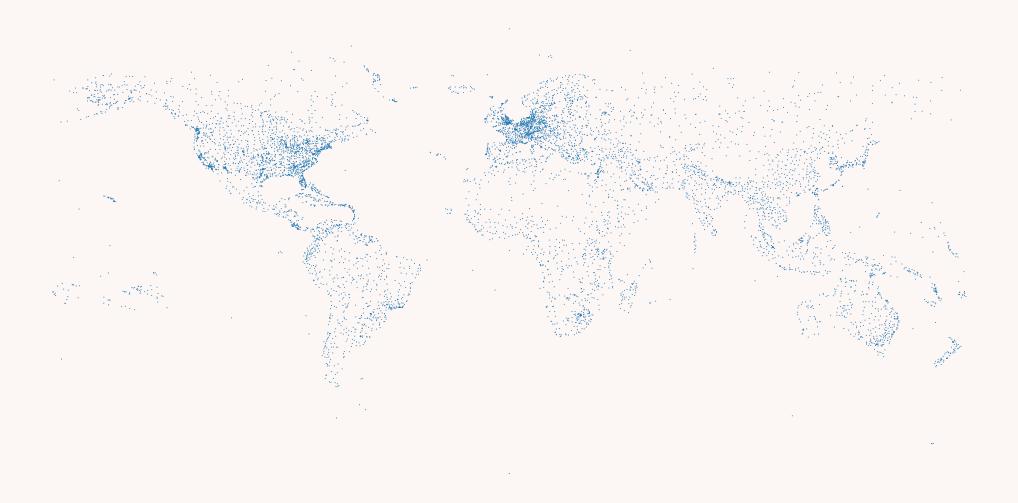

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(18, 9)

ax.scatter(airports['long'], airports['lat'], s=1, alpha=1, edgecolors='none')
ax.axis('off')

plt.show()

<p>The second data set is a csv containing a list of routes. These routes take the form of iata pairs linking the source airport and the destination airport.</p>

In [3]:
routes = pd.read_csv("flight-data/routes.dat", delimiter=',', names=['airline', 'id', 'source_airport', 'source_airport_id',
                                                               'destination_airport', 'destination_airport_id', 'codeshare',
                                                               'stops', 'equitment'])

print(routes)

      airline     id source_airport source_airport_id destination_airport  \
0          2B    410            AER              2965                 KZN   
1          2B    410            ASF              2966                 KZN   
2          2B    410            ASF              2966                 MRV   
3          2B    410            CEK              2968                 KZN   
4          2B    410            CEK              2968                 OVB   
...       ...    ...            ...               ...                 ...   
67658      ZL   4178            WYA              6334                 ADL   
67659      ZM  19016            DME              4029                 FRU   
67660      ZM  19016            FRU              2912                 DME   
67661      ZM  19016            FRU              2912                 OSS   
67662      ZM  19016            OSS              2913                 FRU   

      destination_airport_id codeshare  stops equitment  
0                

The method that we are going to employ to create LineStrings for each route is as follows.

- Create a duplicate airports DataFrame and label one as source and one as destination.
- Merge the source DataFrame with the routes using the routes source iata code.
- Merge the destination DataFrame with the routes using the routes destination iata code.
- Use the latitude and longitude values of the source and destinations airports which are now merged into the routes DataFrame to create a LineString representing that route.

Below we are duplicating the original airports DataFrame and labelling the columns of one with _source and the other with _destination.

In [4]:
source_airports = airports[['name', 'iata', 'icao', 'lat', 'long']]
destination_airports = source_airports.copy()
source_airports.columns = [str(col) + '_source' for col in source_airports.columns]
destination_airports.columns = [str(col) + '_destination' for col in destination_airports.columns]

<p>
These two DataFrames are then merged with the routes DataFrame to give a DataFrame with the latitude/longitude values of the destination and source airports. Note the columns shown below, there are four columns, lat_source, long_source, lat_destination and long_destination for each route.
</p>

In [5]:
routes = routes[['source_airport', 'destination_airport']]
routes = pd.merge(routes, source_airports, left_on='source_airport', right_on='iata_source')
routes = pd.merge(routes, destination_airports, left_on='destination_airport', right_on='iata_destination')

print(routes.columns)

Index(['source_airport', 'destination_airport', 'name_source', 'iata_source',
       'icao_source', 'lat_source', 'long_source', 'name_destination',
       'iata_destination', 'icao_destination', 'lat_destination',
       'long_destination'],
      dtype='object')


In [6]:
import geopandas as gpd
from shapely.geometry import LineString

geometry = [LineString([[routes.iloc[i]['long_source'], routes.iloc[i]['lat_source']], [routes.iloc[i]['long_destination'], routes.iloc[i]['lat_destination']]]) for i in range(routes.shape[0])]
routes = gpd.GeoDataFrame(routes, geometry=geometry, crs='EPSG:4326')
print(routes)

/usr/local/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.11.0-CAPI-1.17.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


      source_airport destination_airport                       name_source  \
0                AER                 KZN       Sochi International Airport   
1                ASF                 KZN                 Astrakhan Airport   
2                CEK                 KZN     Chelyabinsk Balandino Airport   
3                DME                 KZN  Domodedovo International Airport   
4                DME                 KZN  Domodedovo International Airport   
...              ...                 ...                               ...   
66929            ZKE                 YFA               Kashechewan Airport   
66930            YPO                 YAT                 Peawanuck Airport   
66931            ZKE                 YAT               Kashechewan Airport   
66932            JCK                 RCM               Julia Creek Airport   
66933            TRO                 GFN                     Taree Airport   

      iata_source icao_source  lat_source  long_source  \
0    

<p>
    The data can now be plotted to give an airways map. Unfortunately it is not possible to simply plot the data as is because the curvature of the earth needs to be taken into account when plotting the lines. The map below shows direct lines between each airport which is incorrect.
</p>

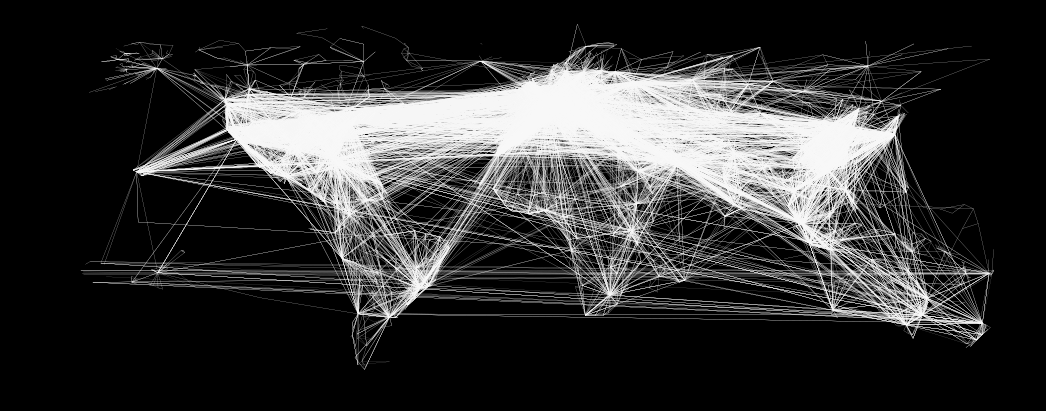

In [7]:
fig = plt.figure(facecolor='black')
ax = plt.axes()

fig.set_size_inches(18, 13.5)
ax.patch.set_facecolor('black')

routes.plot(ax=ax, color='white', linewidth=0.1)

plt.setp(ax.spines.values(), color='black')
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='black')

plt.show()


<p>Cartopy can be used to manipulate the way that lines are plotted. The transform=ccrs.Geodetic() method transforms the LineStrings to account for the earths curvature. I have also changed the projection to the Robinson projection because it is one of the more realistic ways to plot global datasets, accounting for the fact that the earth is not flat. I also have reduced the alpha value to 0.1 to make it a little bit clearer.
</p>

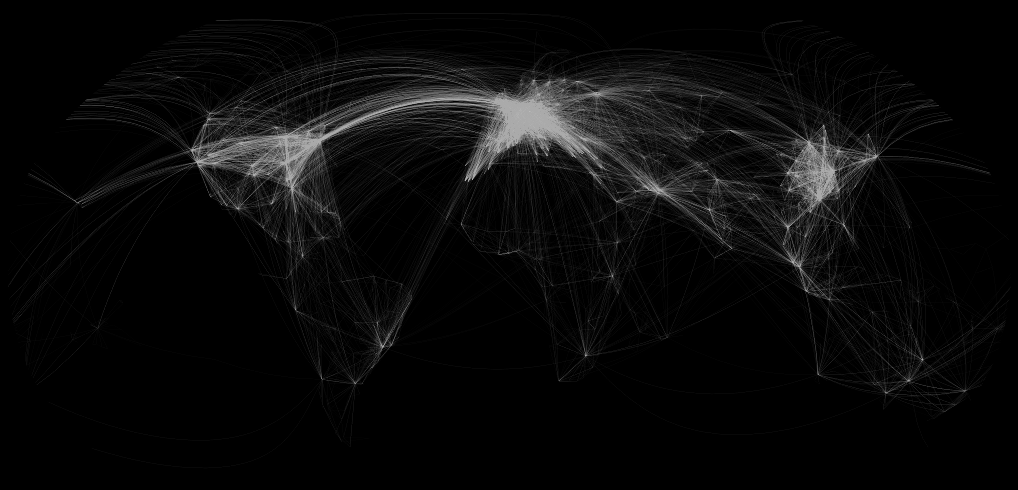

In [9]:
import cartopy.crs as ccrs

fig = plt.figure(facecolor='black')
ax = plt.axes(projection=ccrs.Robinson())
fig.set_size_inches(18, 13.5)
ax.patch.set_facecolor('black')

routes.plot(ax=ax, transform=ccrs.Geodetic(), color='white', linewidth=0.1, alpha=0.1)

plt.setp(ax.spines.values(), color='black')
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='black')
ax.set_ylim(-7000000, 8800000)

plt.show()